# Reduced-order basis

In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from importlib import reload

In [3]:
import lfigw.waveform_generator as wfg

## Dataset

In [4]:
wfd = wfg.WaveformDataset(spins_aligned=False, domain='FD')

### Generate and save

In [5]:
wfd.f_max = 512.0
wfd.delta_f = 1.0
wfd.prior['time'] = [-0.1, 0.1]

In [6]:
wfd.generate_dataset(10000)
wfd.init_training()
wfd.generate_noisy_test_data()

In [7]:
wfd.save('.')
wfd.save_train('.')
wfd.save_noisy_test_data('.')

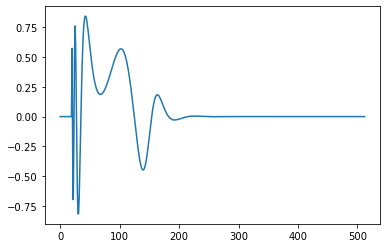

In [8]:
plt.plot(wfd.h_dict['H1'][0].real)

### Load

In [5]:
wfd.load('.')
wfd.load_train('.')
wfd.load_noisy_test_data('.')

## Factor out the time shift $t_c$

The time shift makes a big contribution to the oscillations in the FD waveform, so before constructing a reduced-order basis, we should do our best to remove it. This should result in a smaller basis for the same accuracy. The time shift data can be saved and passed as an extra piece of information to the network.

In [9]:
# Take data from one detector

strain = wfd.h_dict['H1']/wfd._noise_std

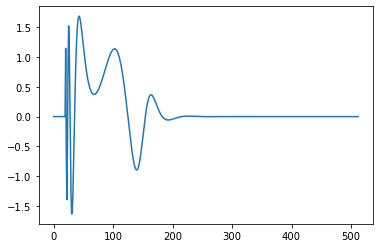

In [10]:
plt.plot(strain[0].real)

In [11]:
strain_ifft = np.fft.irfft(strain)

In [258]:
# Take the peak of the absolute value of the IFFT as the coalescence time. Not perfect, but probably good enough.

# *** How will this work if there is noise? ***

t = np.argmax(np.abs(strain_ifft), axis=-1)

In [13]:
strain_shifted = np.exp( 2 * np.pi * 1j * np.outer(t, range(513)) / 1024) * strain

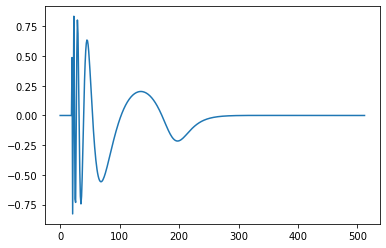

In [14]:
plt.plot(strain_shifted[1].imag)

In [15]:
strain_shifted_ifft = np.fft.irfft(strain_shifted)

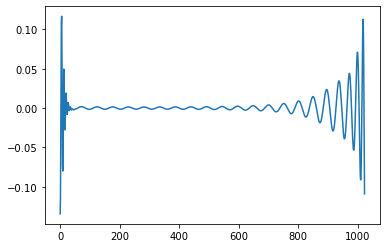

In [16]:
# All the waveforms now coalesce at t=0

plt.plot(strain_shifted_ifft[4])

### Noisy case

In [45]:
start_idx = int(wfd.f_min / wfd.delta_f)

In [101]:
strain_noisy = strain + np.pad(np.random.randn(10000, 513 - start_idx) + 1j * np.random.randn(10000, 513 - start_idx), ((0, 0), (start_idx, 0)))

In [70]:
strain_noisy_ifft = np.fft.irfft(strain_noisy)

In [71]:
strain_ifft_smooth = np.fft.irfft(strain)

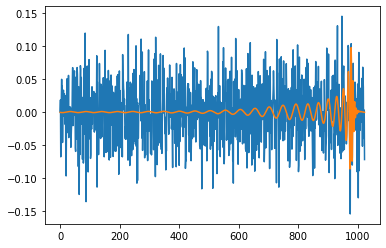

In [105]:
plt.plot(strain_noisy_ifft[1].real)
plt.plot(strain_ifft_smooth[1].real)
plt.show()

If SNR is too low, how can we pick out the peak?

#### Cross-check on noise

I just want to make sure I'm adding the right amount of noise. Ignore this if uninterested.

In [77]:
import pycbc

In [106]:
fseries_1 = pycbc.types.frequencyseries.FrequencySeries(strain_noisy[1] * wfd._noise_std * np.sqrt(wfd.delta_t * 2.0), delta_f=wfd.delta_f)
tseries_1 = fseries_1.to_timeseries()

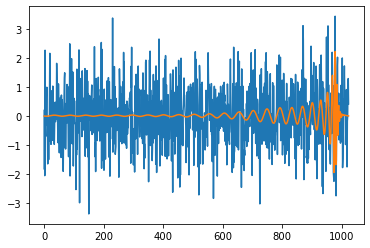

In [113]:
plt.plot(tseries_1.numpy())
plt.plot(test)
plt.show()

In [114]:
np.mean(tseries_1.numpy()**2)

1.0568190566800606

In [108]:
fseries = pycbc.types.frequencyseries.FrequencySeries(strain[1] * wfd._noise_std, delta_f=wfd.delta_f)

In [109]:
tseries = fseries.to_timeseries()

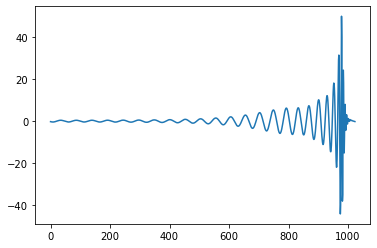

In [110]:
plt.plot(tseries.numpy())

In [111]:
test = tseries.numpy() * np.sqrt(wfd.delta_t * 2.0)
test_noisy = test + np.random.randn(1024)

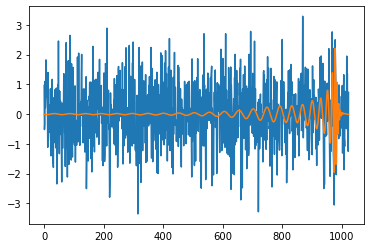

In [112]:
plt.plot(test_noisy)
plt.plot(test)
plt.show()

In [115]:
np.mean(test_noisy**2)

1.0565792144572355

## SVD

In [17]:
import scipy

In [125]:
# strain = U S Vh

#    where S is diagonal with s = diag(S), and
#          U, Vh are unitary.

U, s, Vh = scipy.linalg.svd(strain, full_matrices=False)

In [126]:
U_shifted, s_shifted, Vh_shifted = scipy.linalg.svd(strain_shifted, full_matrices=False)

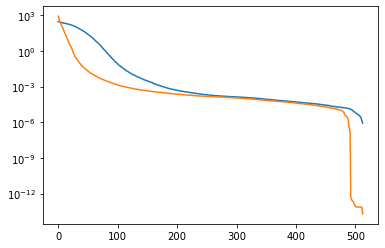

In [127]:
plt.plot(s)
plt.plot(s_shifted)
plt.yscale('log')
plt.show()

From the figure, and depending on the accuracy threshold, we may be able to get away with fewer basis elements if we use the time shift.

In [128]:
U.shape

(10000, 513)

In [129]:
Vh.shape

(513, 513)

### Transform waveforms to SVD basis and evaluate mismatch

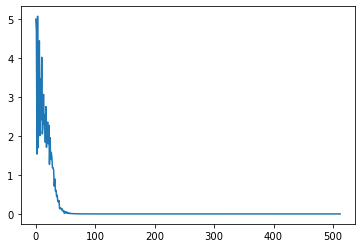

In [136]:
# Magnitude of basis coefficients for one example waveform

plt.plot(np.abs(U[0] * s))

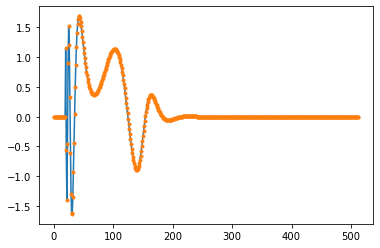

In [146]:
# With just 50 components, waveform looks indistinguishable

plt.plot(((U[0] * s)[:50] @ Vh[:50,:]).real)
plt.plot(strain[0], '.')
plt.show()

In [188]:
end = 200
means = np.empty(end)
stds = np.empty(end)
mins = np.empty(end)
maxs = np.empty(end)
for truncation in range(end):
    reconstructed = (U @ np.diag(s))[:,:truncation] @ Vh[:truncation,:]
    norms = np.mean(np.abs(strain)**2, axis=-1)
    reconstructed_norms = np.mean(np.abs(reconstructed)**2, axis=-1)
    matches = np.mean(reconstructed.conj() * strain, axis=-1).real
    faithfulness = matches / np.sqrt(norms * reconstructed_norms)
    
    means[truncation] = np.mean(faithfulness)
    stds[truncation] = np.std(faithfulness)
    mins[truncation] = np.min(faithfulness)
    maxs[truncation] = np.max(faithfulness)
    

/Users/stephen/anaconda3/envs/lal/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


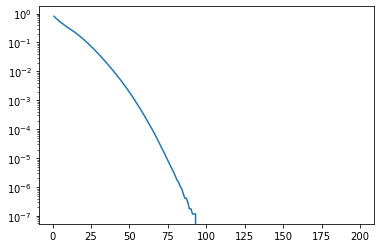

In [189]:
plt.plot(1- means)
plt.yscale('log')

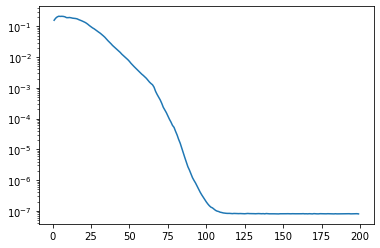

In [190]:
plt.plot(stds)
plt.yscale('log')

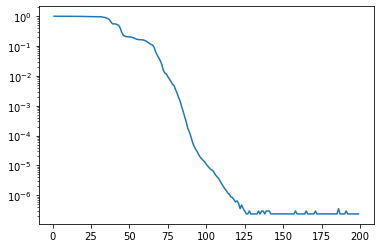

In [191]:
plt.plot(1-mins)
plt.yscale('log')

It appears that, even without worrying about the time shift, we should be able to get away with 100 basis elements. This is a factor of 5 smaller than the number of frequency bins. Moreover, this factor should improve as we move to longer waveforms.

### Incorporate time shift separately

In [192]:
end = 200
means = np.empty(end)
stds = np.empty(end)
mins = np.empty(end)
maxs = np.empty(end)
for truncation in range(end):
    reconstructed = (U_shifted @ np.diag(s_shifted))[:,:truncation] @ Vh_shifted[:truncation,:]
    norms = np.mean(np.abs(strain_shifted)**2, axis=-1)
    reconstructed_norms = np.mean(np.abs(reconstructed)**2, axis=-1)
    matches = np.mean(reconstructed.conj() * strain_shifted, axis=-1).real
    faithfulness = matches / np.sqrt(norms * reconstructed_norms)
    
    means[truncation] = np.mean(faithfulness)
    stds[truncation] = np.std(faithfulness)
    mins[truncation] = np.min(faithfulness)
    maxs[truncation] = np.max(faithfulness)

/Users/stephen/anaconda3/envs/lal/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


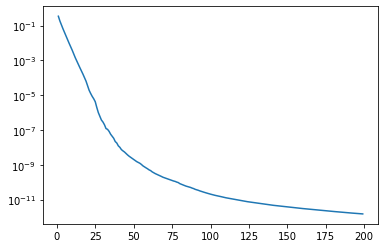

In [193]:
plt.plot(1- means)
plt.yscale('log')

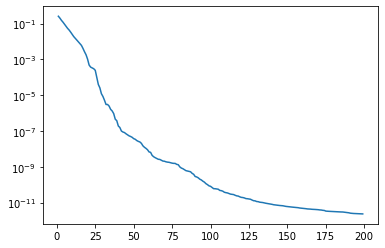

In [194]:
plt.plot(stds)
plt.yscale('log')

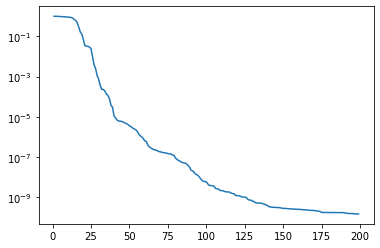

In [195]:
plt.plot(1-mins)
plt.yscale('log')

With the time shift, we could get away with half as many basis elements.

## Reduced basis class

In [6]:
import reduced_basis

In [12]:
reload(reduced_basis)

<module 'reduced_basis' from '../src/reduced_basis.py'>

In [19]:
basis = reduced_basis.SVDBasis()

In [21]:
basis.load()

In [14]:
basis.generate_basis(strain, 100)

In [23]:
basis.init_time_translation(-0.15, 0.15, 1001, np.linspace(0, 512, 513))

In [24]:
basis.init_whitening(wfd.psd_names['H1'], wfd._get_psd(wfd.delta_f, 'H1'),
                     wfd.psd_names['V1'], wfd._get_psd(wfd.delta_f, 'V1'))

In [29]:
basis.whitening_dict[wfd.psd_names['V1']][:5,:5].real

array([[ 0.59555776, -0.00544563, -0.01032737, -0.00086967,  0.00752321],
       [-0.00544563,  0.59597874, -0.02465154, -0.02377447,  0.01518972],
       [-0.01032737, -0.02465154,  0.60268561, -0.02550515,  0.01381235],
       [-0.00086967, -0.02377447, -0.02550515,  0.60551145,  0.03780972],
       [ 0.00752321,  0.01518972,  0.01381235,  0.03780972,  0.60159911]])

In [26]:
coeffs = basis.fseries_to_basis_coefficients(strain[1])

In [27]:
coeffs_V1 = basis.whiten(coeffs, wfd.psd_names['V1'])
coeffs_H1 = basis.whiten(coeffs, wfd.psd_names['H1'])

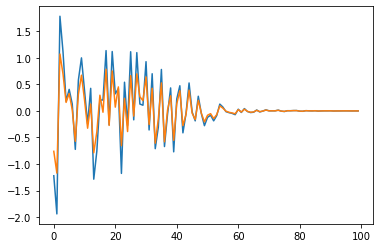

In [28]:
plt.plot(coeffs.imag)
plt.plot(coeffs_V1.imag)
plt.show()

In [56]:
strain_RB = np.empty((len(strain), 100), dtype=np.complex64)
for i in range(len(strain)):
    strain_RB[i] = basis.fseries_to_basis_coefficients(strain[i])

In [57]:
for i in range(len(strain_RB)):
    _ = basis.whiten(strain_RB[i], wfd.psd_names['V1'])

In [53]:
len(strain)

10000

In [44]:
basis.V

array([[ 8.1303975e-10-0.0000000e+00j, -7.9664864e-10-0.0000000e+00j,
         2.7208014e-10-0.0000000e+00j, ...,
         1.2839202e-07-0.0000000e+00j,  5.8792484e-08-0.0000000e+00j,
         1.4293819e-07-0.0000000e+00j],
       [-5.9604645e-08+1.3387915e-07j, -2.9802322e-08+4.1745352e-08j,
        -5.2154064e-08-9.1713446e-09j, ...,
         1.5587109e-05-1.2616176e-05j,  3.2644828e-05+3.2652169e-06j,
         3.4583540e-05-7.7490695e-06j],
       [-8.9406967e-08-1.6620220e-08j,  8.9406967e-08-1.1666998e-08j,
        -5.9604645e-08+6.0012098e-08j, ...,
         1.5256568e-05-3.2997690e-05j, -1.6019856e-05-1.7003156e-05j,
         3.1978932e-05-2.2466294e-05j],
       ...,
       [ 4.4340696e-09-2.6456770e-09j,  5.1097265e-11-1.0775828e-08j,
         3.0104292e-09+2.1158493e-09j, ...,
        -1.8868755e-04-1.0572399e-05j,  8.9173511e-05-2.1157868e-04j,
        -2.7696564e-04-2.8262759e-04j],
       [ 2.6990439e-09-2.1789390e-09j,  3.1477447e-09-1.0918669e-08j,
         5.4268728e-10

In [43]:
basis.whitening_dict['AdVDesignSensitivityP1200087']

array([[ 5.95557764e-01+1.04083408e-17j, -5.44563319e-03-2.56909105e-02j,
        -1.03273747e-02-4.66762996e-03j, ...,
         4.76554232e-07-1.82155240e-07j,  7.85745476e-07-4.30349732e-07j,
         4.93187136e-08-3.14585030e-07j],
       [-5.44563319e-03+2.56909105e-02j,  5.95978741e-01-2.71050547e-20j,
        -2.46515383e-02+2.11053795e-02j, ...,
        -3.29201123e-07-5.37329243e-07j,  2.63861540e-07-3.23004121e-07j,
        -3.39185420e-07-9.38651987e-08j],
       [-1.03273747e-02+4.66762996e-03j, -2.46515383e-02-2.11053795e-02j,
         6.02685614e-01-1.39048929e-17j, ...,
         3.27256643e-07-1.83516195e-07j,  2.20576573e-08+5.64098393e-07j,
        -5.06860247e-07-1.88106390e-07j],
       ...,
       [ 4.76554232e-07+1.82155240e-07j, -3.29201123e-07+5.37329243e-07j,
         3.27256643e-07+1.83516195e-07j, ...,
         7.61335983e-01-8.67361738e-18j, -3.95088804e-03+3.54774995e-02j,
        -2.54185857e-02-8.30326078e-03j],
       [ 7.85745476e-07+4.30349732e-07j,  2.

In [42]:
basis.whitening_dict['AdVDesignSensitivityP1200087'].astype(np.complex64)

array([[ 5.9555775e-01+1.0408341e-17j, -5.4456331e-03-2.5690911e-02j,
        -1.0327375e-02-4.6676300e-03j, ...,
         4.7655422e-07-1.8215523e-07j,  7.8574550e-07-4.3034973e-07j,
         4.9318714e-08-3.1458504e-07j],
       [-5.4456331e-03+2.5690911e-02j,  5.9597874e-01-2.7105054e-20j,
        -2.4651539e-02+2.1105379e-02j, ...,
        -3.2920113e-07-5.3732924e-07j,  2.6386155e-07-3.2300412e-07j,
        -3.3918542e-07-9.3865197e-08j],
       [-1.0327375e-02+4.6676300e-03j, -2.4651539e-02-2.1105379e-02j,
         6.0268563e-01-1.3904893e-17j, ...,
         3.2725663e-07-1.8351619e-07j,  2.2057657e-08+5.6409840e-07j,
        -5.0686026e-07-1.8810638e-07j],
       ...,
       [ 4.7655422e-07+1.8215523e-07j, -3.2920113e-07+5.3732924e-07j,
         3.2725663e-07+1.8351619e-07j, ...,
         7.6133597e-01-8.6736174e-18j, -3.9508878e-03+3.5477500e-02j,
        -2.5418585e-02-8.3032604e-03j],
       [ 7.8574550e-07+4.3034973e-07j,  2.6386155e-07+3.2300412e-07j,
         2.2057657e-08

In [50]:
(basis.T_matrices[0,0,0] * 3.0).dtype

dtype('complex128')

In [18]:
basis.save()

### Performance evaluation

In [51]:
from pycbc.waveform import get_fd_waveform

In [271]:
wfd._sample_prior(1)

In [53]:
pars = wfd.parameters[0]

In [97]:
pars[3]

0.03982498

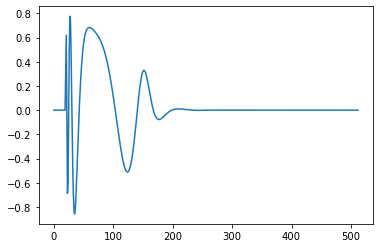

In [102]:
plt.plot(wfd.h_dict['H1'][0].imag)

In [273]:
wfd.param_idx

{'mass_1': 0,
 'mass_2': 1,
 'phase': 2,
 'time': 3,
 'distance': 4,
 'a_1': 5,
 'a_2': 6,
 'tilt_1': 7,
 'tilt_2': 8,
 'phi_12': 9,
 'phi_jl': 10,
 'theta_jn': 11,
 'psi': 12,
 'ra': 13,
 'dec': 14}

In [79]:
hp_fd, hc_fd = get_fd_waveform(mass1=pars[0], mass2=pars[1], distance=pars[4], coa_phase=pars[2], 
                               f_lower=wfd.f_min, f_final=wfd.f_max, delta_f=wfd.delta_f, f_ref=wfd.f_ref, approximant=wfd.approximant)
fs = hp_fd.sample_frequencies
hp_fd = hp_fd / (wfd._get_psd(hp_fd.delta_f, 'H1') ** 0.5)
hc_fd = hc_fd / (wfd._get_psd(hc_fd.delta_f, 'H1') ** 0.5)

In [105]:
hp_fd_p, hc_fd_p = get_fd_waveform(mass1=pars[0], mass2=pars[1], distance=pars[4], coa_phase=pars[2] + np.pi, 
                               f_lower=wfd.f_min, f_final=wfd.f_max, delta_f=wfd.delta_f, f_ref=wfd.f_ref, approximant=wfd.approximant)
hp_fd_p = hp_fd_p.cyclic_time_shift(-1.01)
hc_fd_p = hc_fd_p.cyclic_time_shift(-1.01)
hp_fd_p = hp_fd_p / (wfd._get_psd(hp_fd.delta_f, 'H1') ** 0.5)
hc_fd_p = hc_fd_p / (wfd._get_psd(hc_fd.delta_f, 'H1') ** 0.5)

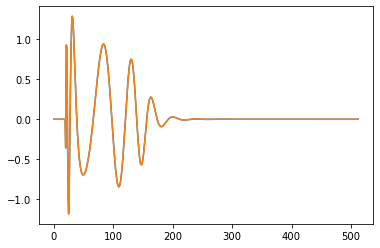

In [83]:
plt.plot((hp_fd.numpy() * np.exp(-2j * np.pi * 0.03 * fs.numpy())).real)
plt.plot(hp_fd_p.numpy().real)
plt.show()

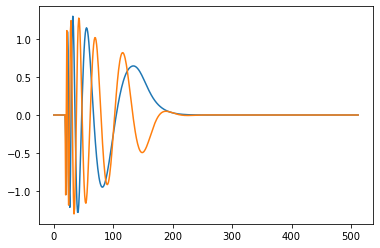

In [106]:
plt.plot((hp_fd.numpy() * np.exp(-1j *0)).real)
plt.plot(hp_fd_p.numpy().real)
plt.show()

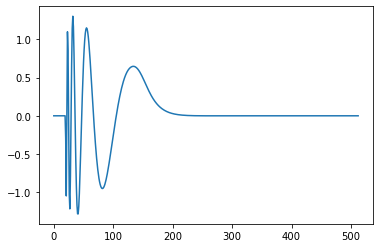

In [61]:
plt.plot(hp_fd_p.numpy().imag)

In [381]:
dt = -0.0989
hp_fd_translated = hp_fd.cyclic_time_shift(dt)
hc_fd_translated = hc_fd.cyclic_time_shift(dt)

In [336]:
basis.t_grid[150:200]

array([-0.105 , -0.1047, -0.1044, -0.1041, -0.1038, -0.1035, -0.1032,
       -0.1029, -0.1026, -0.1023, -0.102 , -0.1017, -0.1014, -0.1011,
       -0.1008, -0.1005, -0.1002, -0.0999, -0.0996, -0.0993, -0.099 ,
       -0.0987, -0.0984, -0.0981, -0.0978, -0.0975, -0.0972, -0.0969,
       -0.0966, -0.0963, -0.096 , -0.0957, -0.0954, -0.0951, -0.0948,
       -0.0945, -0.0942, -0.0939, -0.0936, -0.0933, -0.093 , -0.0927,
       -0.0924, -0.0921, -0.0918, -0.0915, -0.0912, -0.0909, -0.0906,
       -0.0903])

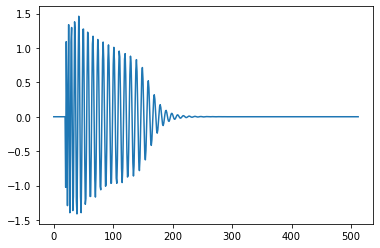

In [327]:
plt.plot(hp_fd_translated.numpy().imag)

In [382]:
hp = np.empty(513, dtype=np.complex64)
hp[:] = hp_fd

hp_translated = np.empty(513, dtype=np.complex64)
hp_translated[:] = hp_fd_translated

##### Transform to basis

In [298]:
coeff = basis.fseries_to_basis_coefficients(hp)

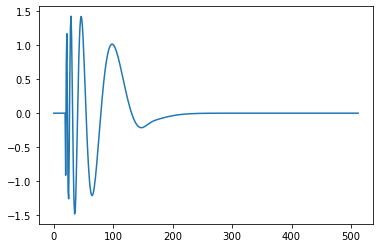

In [299]:
plt.plot(basis.basis_coefficients_to_fseries(coeff).imag)

In [306]:
match = np.sum(hp.conj() * basis.basis_coefficients_to_fseries(coeff)) / np.sqrt(np.sum(np.abs(hp)**2) * np.sum(np.abs(basis.basis_coefficients_to_fseries(coeff))**2))

In [307]:
match

(1.0000001-7.874908e-09j)

In [383]:
coeff_translated = basis.time_translate(coeff, dt, interpolation='cubic')

In [388]:
test = basis.fseries_to_basis_coefficients(hp_translated)

In [331]:
np.sum(hp_translated.conj() * basis.basis_coefficients_to_fseries(test)) / np.sqrt(np.sum(np.abs(hp_translated)**2) * np.sum(np.abs(basis.basis_coefficients_to_fseries(test))**2))

(1.0000001+2.6865805e-09j)

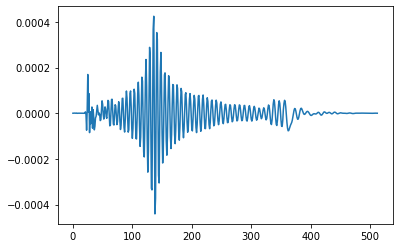

In [386]:
plt.plot(basis.basis_coefficients_to_fseries(coeff_translated).real - hp_translated.real)

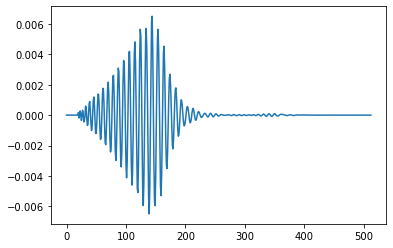

In [373]:
plt.plot(basis.basis_coefficients_to_fseries(coeff_translated).imag - hp_translated.imag)

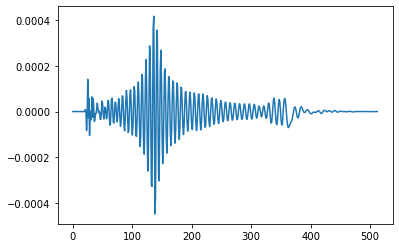

In [389]:
plt.plot(basis.basis_coefficients_to_fseries(test).real - hp_translated.real)

In [391]:
1-np.sum(hp_translated.conj() * basis.basis_coefficients_to_fseries(coeff_translated)) / np.sqrt(np.sum(np.abs(hp_translated)**2) * np.sum(np.abs(basis.basis_coefficients_to_fseries(coeff_translated))**2))

-8.163927134319238e-08j

In [255]:
sample_times = np.linspace(0,1,1024,endpoint=False)

In [31]:
test = dict(mass_1=0, mass_2=1, phase=2, time=3, distance=4)

In [34]:
test['mass_1']

0

In [36]:
np.random.random(4, dtype=np.float32)

TypeError: random() got an unexpected keyword argument 'dtype'

In [108]:
x = [1,2,3]

In [111]:
x*

SyntaxError: invalid syntax (<ipython-input-111-656fbcc9f16a>, line 1)

In [114]:
from lal import REARTH_SI, C_SI

In [116]:
2 * REARTH_SI / C_SI

0.04255034728058436

## Time shifting performance

Study how basis truncation affects the ability to time-shift waveforms.

In [1]:
import sys
sys.path.append('../src/')

import waveform_generator as wfg
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load a waveform dataset
wfd = wfg.WaveformDataset()
wfd.load_noisy_test_data('../waveforms/GW150914')

In [3]:
wfd.load_event('../data/events/GW150914')

In [4]:
wfd.initialize_reduced_basis_aux()

  0%|          | 1/1001 [00:00<03:08,  5.31it/s]

Building time translation matrices.


100%|██████████| 1001/1001 [04:01<00:00,  4.15it/s]


In [5]:
idx = 2
ntimes = 300
ifo = 'L1'
Nrb = 300

p = wfd.noisy_waveforms_parameters[idx,:].astype(np.float64)
p[wfd.param_idx['time']] = 0.0
h_FD = wfd._generate_whitened_waveform(p)
h_FD = h_FD[ifo]

matches = []
times = np.linspace(wfd.basis.t_grid[0], wfd.basis.t_grid[-1], ntimes)
# times = wfd.basis.t_grid
for dt in tqdm(times):
    h_FD_dt = h_FD * np.exp(- 2 * np.pi * 1j * wfd.sample_frequencies * dt)
    h_RB = (h_FD_dt @ wfd.basis.V)[:Nrb]
    h_FD_dt_recon = h_RB @ wfd.basis.Vh[:Nrb]
    
    # compute mismatch
    norm1 = np.mean(np.abs(h_FD_dt)**2)
    norm2 = np.mean(np.abs(h_FD_dt_recon)**2)
    inner = np.mean(h_FD_dt.conj()*h_FD_dt_recon).real

    matches.append(inner / np.sqrt(norm1 * norm2))
    
mismatches = 1 - np.array(matches)

100%|██████████| 300/300 [00:19<00:00, 15.41it/s]


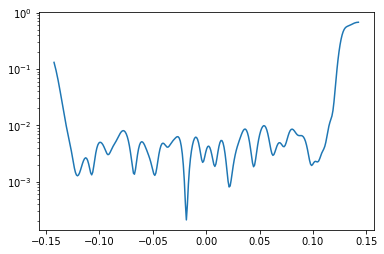

In [53]:
# Nrb 100 L1

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

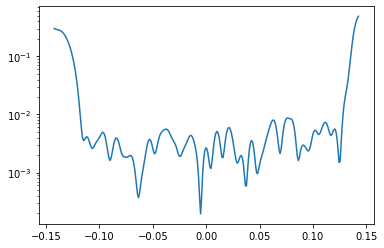

In [36]:
# Nrb 100 H1

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

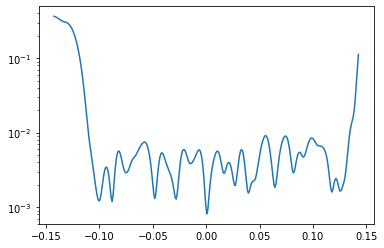

In [51]:
# Nrb 100 L1

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

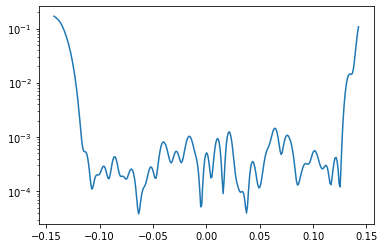

In [38]:
# Nrb 200

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

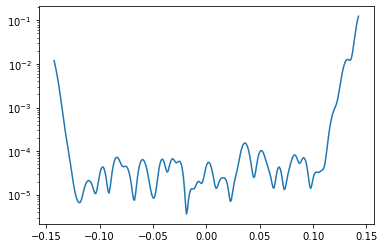

In [6]:
# Nrb 300

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

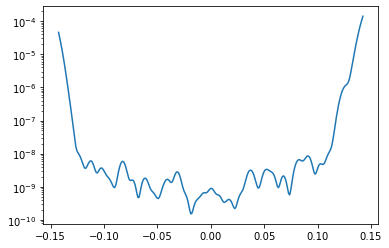

In [6]:
# Nrb 600

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

The biggest factor seems to be basis truncation

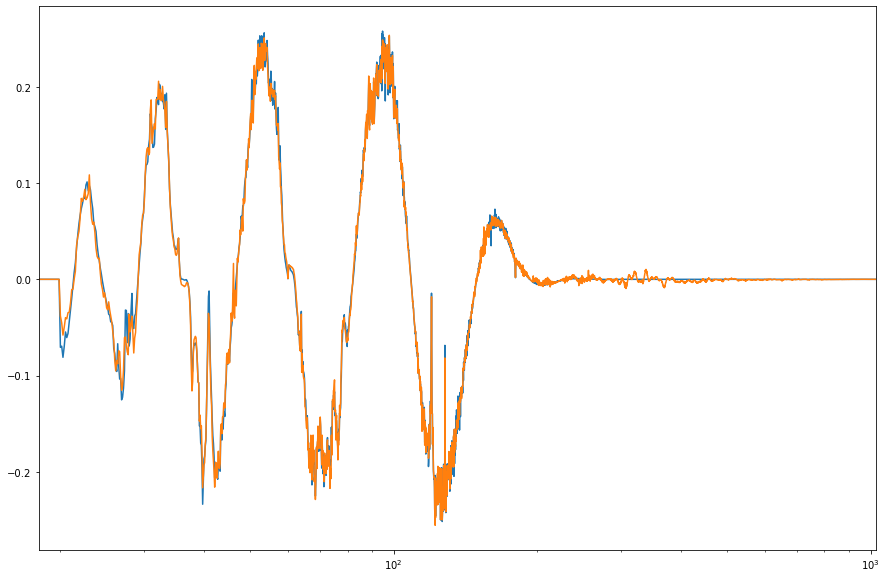

In [49]:
plt.figure(figsize=(15,10))
plt.plot(wfd.sample_frequencies, h_FD.real)
plt.plot(wfd.sample_frequencies, ((h_FD @ wfd.basis.V)[:Nrb] @ wfd.basis.Vh[:Nrb]).real)
plt.xscale('log')
plt.xlim((18,1024))
plt.show()

#### Check on GW150914 mean params

In [7]:
import h5py

In [10]:
f = h5py.File('../data/events/GW150914/GW150914_data.h5', 'r')
PhenomPv2_samples = f['allIsp_post']

ligo_samples = np.zeros((len(PhenomPv2_samples), 15))
ligo_samples[:, wfd.param_idx['mass_1']] = PhenomPv2_samples['mass1_det']
ligo_samples[:, wfd.param_idx['mass_2']] = PhenomPv2_samples['mass2_det']
ligo_samples[:, wfd.param_idx['a_1']] = PhenomPv2_samples['a1']
ligo_samples[:, wfd.param_idx['a_2']] = PhenomPv2_samples['a2']
ligo_samples[:, wfd.param_idx['tilt_1']] = PhenomPv2_samples['tilt1']
ligo_samples[:, wfd.param_idx['tilt_2']] = PhenomPv2_samples['tilt2']
ligo_samples[:, wfd.param_idx['distance']] = PhenomPv2_samples['distance']
ligo_samples[:, wfd.param_idx['theta_jn']] = PhenomPv2_samples['theta_jn']
ligo_samples[:, wfd.param_idx['time']] = PhenomPv2_samples['time'] - wfd.ref_time
ligo_samples[:, wfd.param_idx['ra']] = PhenomPv2_samples['right_ascension']
ligo_samples[:, wfd.param_idx['dec']] = PhenomPv2_samples['declination']

f.close()

In [12]:
ligo_samples.mean(axis=0)

array([ 3.88919824e+01,  3.22973875e+01,  0.00000000e+00,  1.61718850e-02,
        4.35676710e+02,  3.51055160e-01,  3.97095939e-01,  1.65317287e+00,
        1.78002821e+00,  0.00000000e+00,  0.00000000e+00,  2.57105655e+00,
        0.00000000e+00,  1.88762551e+00, -1.16347913e+00])

In [21]:
ntimes = 100
ifo = 'L1'
Nrb = 100

p = ligo_samples.mean(axis=0)
p[wfd.param_idx['time']] = 0.0
h_FD = wfd._generate_whitened_waveform(p)
h_FD = h_FD[ifo]

matches = []
times = np.linspace(wfd.basis.t_grid[0], wfd.basis.t_grid[-1], ntimes)
# times = wfd.basis.t_grid
for dt in tqdm(times):
    h_FD_dt = h_FD * np.exp(- 2 * np.pi * 1j * wfd.sample_frequencies * dt)
    h_RB = (h_FD_dt @ wfd.basis.V)[:Nrb]
    h_FD_dt_recon = h_RB @ wfd.basis.Vh[:Nrb]
    
    # compute mismatch
    norm1 = np.mean(np.abs(h_FD_dt)**2)
    norm2 = np.mean(np.abs(h_FD_dt_recon)**2)
    inner = np.mean(h_FD_dt.conj()*h_FD_dt_recon).real

    matches.append(inner / np.sqrt(norm1 * norm2))
    
mismatches = 1 - np.array(matches)

100%|██████████| 100/100 [00:04<00:00, 24.32it/s]


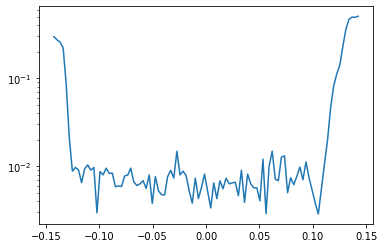

In [23]:
# Nrb 100 L1

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

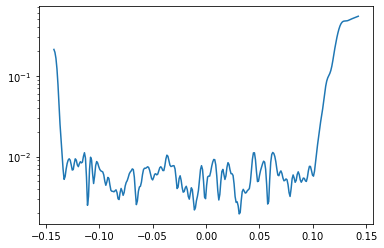

In [16]:
# Nrb 100 H1

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

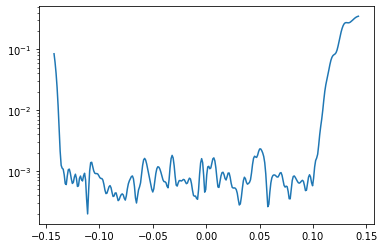

In [18]:
# Nrb 200

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

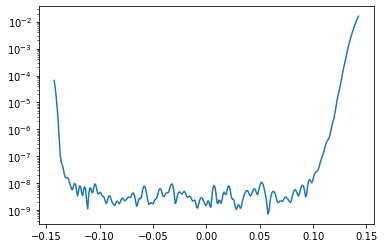

In [14]:
# Nrb 600

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

### Evaluate interpolation of T-matrices

In [39]:
wfd.basis.truncate(100)

In [44]:
idx = 1
ntimes = 300
ifo = 'H1'
Nrb = 200

p = wfd.noisy_waveforms_parameters[idx,:].astype(np.float64)
p[wfd.param_idx['time']] = 0.0
h_FD = wfd._generate_whitened_waveform(p)
h_FD = h_FD[ifo]

matches = []
times = np.linspace(wfd.basis.t_grid[200], wfd.basis.t_grid[205], ntimes)
# times = wfd.basis.t_grid
for dt in tqdm(times):
    h_FD_dt = h_FD * np.exp(- 2 * np.pi * 1j * wfd.sample_frequencies * dt)
    h_RB = (h_FD @ wfd.basis.V)[:Nrb]
    h_RB_dt = wfd.basis.time_translate(h_RB, dt, interpolation='linear')
    h_FD_dt_recon = h_RB_dt @ wfd.basis.Vh[:Nrb]
    
    # compute mismatch
    norm1 = np.mean(np.abs(h_FD_dt)**2)
    norm2 = np.mean(np.abs(h_FD_dt_recon)**2)
    inner = np.mean(h_FD_dt.conj()*h_FD_dt_recon).real

    matches.append(inner / np.sqrt(norm1 * norm2))
    
mismatches = 1 - np.array(matches)

100%|██████████| 300/300 [00:04<00:00, 63.64it/s]


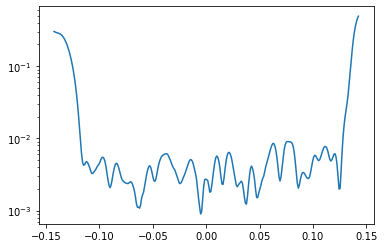

In [41]:
plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

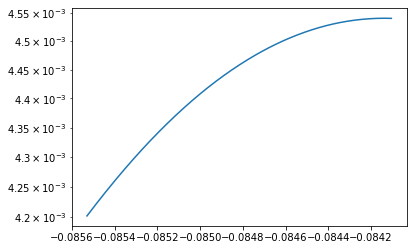

In [43]:
# cubic

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

Seems very smooth

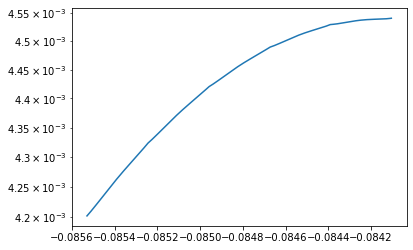

In [45]:
# linear

plt.plot(times, mismatches)
plt.yscale('log')
plt.show()

In [48]:
wfd.basis.t_grid[200:206]

array([-0.08553021, -0.08524511, -0.08496001, -0.08467491, -0.08438981,
       -0.0841047 ], dtype=float32)

Only slightly less smooth. Clearly most of the error comes from truncation.